In [432]:
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency, ttest_ind, pearsonr
from sklearn import set_config

set_config(transform_output="pandas")

# link to Kaggle competition
# https://www.kaggle.com/competitions/mlpro-classification-bank-churn-2025


In [433]:
# Dataset
# Customer ID : Un identifiant pour chaque client
# Surname : Le nom de famille du client
# Credit Score : Une valeur numérique représentant le score de crédit du client
# Geography : Le pays où réside le client (France, Spain ou Germany)
# Gender : Le genre du client (Male or Female)
# Age : L’âge du client
# Tenure : Le nombre d’années pendant lesquelles le client est avec la banque
# Balance : Le solde du compte du client
# NumOfProducts : Le nombre de produits bancaires utilisés par le client (par exemple, compte d’épargne, carte de crédit)
# HasCrCard : Si le client possède une carte de crédit (1 = oui, 0 = non)
# IsActiveMember : Si le client est un membre actif (1 = oui, 0 = non)
# EstimatedSalary : Le salaire estimé du client
# Exited : Si le client a résilié (1 = oui, 0 = non)

from sklearn.model_selection import train_test_split


df = pd.read_csv('data/train_data.csv')
df_exited = df["Exited"]

train_set, test_set = train_test_split(df, test_size=0.2)
print(train_set.shape)
print(test_set.shape)


(114863, 14)
(28716, 14)


### Traitement des NaNs

In [434]:
df.isna().sum(axis = 0)
# Pas de NaN

ID                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## Preprocessing

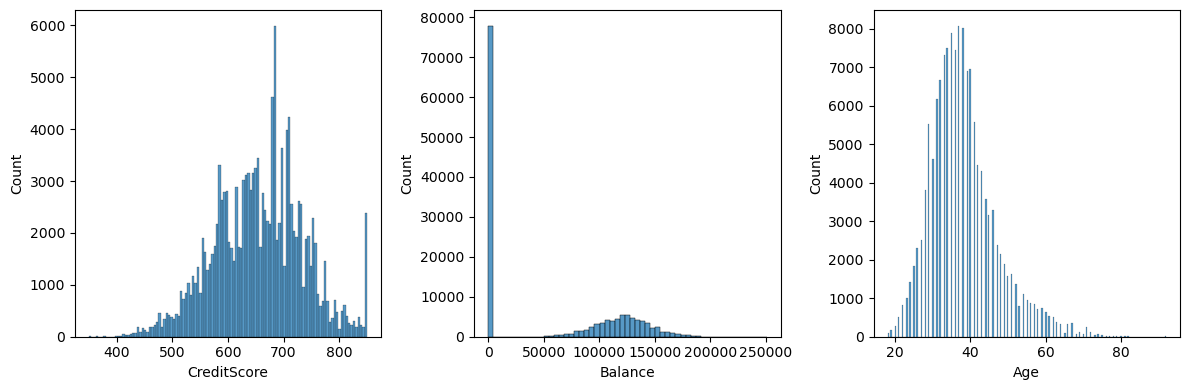

In [435]:
from pyparsing import C
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler


fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(df, x="CreditScore", ax = ax[0])
sns.histplot(df, x="Balance", ax = ax[1])
sns.histplot(df, x="Age", ax = ax[2])
plt.tight_layout()
plt.show()


In [436]:
# Encoding des variable Geography et Gender

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


column_transformer = ColumnTransformer(transformers=[
   ("Encoder", OneHotEncoder(sparse_output=False, drop="first"), ["Geography", "Gender"]),
   ("MinMaxScaler", MinMaxScaler(), ['Tenure', 'NumOfProducts', 'Balance']),
   ("StandardScaler", StandardScaler(), ['CreditScore', 'Age'])], 
   remainder="passthrough",
   verbose_feature_names_out=False)

pipeline = Pipeline(steps=[("Encoding + Normalisation", column_transformer)])
training_df = pipeline.fit_transform(train_set)
training_df


,Geography_Germany,Geography_Spain,Gender_Male,Tenure,NumOfProducts,Balance,CreditScore,Age,ID,CustomerId,Surname,HasCrCard,IsActiveMember,EstimatedSalary,Exited
120728,0.0,1.0,0.0,1.0,0.000000,0.323009,-0.266569,0.657118,129879,15592028,Ting,1.0,1.0,72924.56,0
110308,0.0,0.0,0.0,0.2,0.000000,0.000000,-0.740546,0.319721,160765,15665579,Cartwright,0.0,1.0,94142.35,1
37675,0.0,0.0,1.0,0.6,0.333333,0.000000,0.032786,-1.029864,63241,15799217,Horsley,0.0,1.0,8982.75,0
88678,0.0,0.0,0.0,0.3,0.333333,0.000000,-0.940116,3.356290,91882,15674637,White,1.0,1.0,162961.79,0
124809,0.0,1.0,0.0,0.2,0.333333,0.000000,-0.054526,-1.029864,128231,15744327,Tsao,1.0,1.0,102906.85,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101178,0.0,0.0,0.0,0.2,0.333333,0.000000,-0.066999,-0.242606,4495,15583393,Ts'ui,1.0,1.0,119127.71,0
109225,1.0,0.0,1.0,0.6,0.000000,0.490036,0.955795,0.319721,65166,15709741,Smith,1.0,0.0,100637.07,0
5853,0.0,0.0,1.0,0.7,0.333333,0.000000,-0.004633,-0.242606,120877,15790322,Lucciano,1.0,1.0,98894.64,0
84704,0.0,0.0,1.0,0.7,0.333333,0.000000,0.332140,-1.142330,93425,15690744,Tien,1.0,0.0,175071.18,0


### Transform test data set

In [437]:
df_test = pipeline.transform(test_set)
df_test

,Geography_Germany,Geography_Spain,Gender_Male,Tenure,NumOfProducts,Balance,CreditScore,Age,ID,CustomerId,Surname,HasCrCard,IsActiveMember,EstimatedSalary,Exited
121568,0.0,1.0,1.0,0.8,0.333333,0.000000,-0.179257,-1.367261,112124,15737169,Murphy,1.0,1.0,184399.76,0
65004,0.0,1.0,0.0,0.8,0.666667,0.513853,1.155365,1.894238,130148,15681274,Hs?eh,0.0,0.0,103603.74,1
35660,1.0,0.0,1.0,0.5,0.333333,0.502505,-0.129364,-0.804933,17138,15570194,Hsieh,1.0,0.0,94911.66,0
70941,0.0,0.0,0.0,0.5,0.333333,0.000000,-0.303988,-0.130140,55323,15674583,T'ao,1.0,0.0,104936.84,0
80620,0.0,0.0,0.0,0.5,0.666667,0.000000,0.930849,0.657118,98499,15602811,P'eng,0.0,0.0,70730.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13126,0.0,0.0,0.0,0.1,0.000000,0.429401,-0.079472,2.681497,121531,15713596,Ugochukwu,0.0,1.0,58381.77,0
14198,1.0,0.0,1.0,0.4,0.333333,0.454196,0.606548,0.432187,144409,15643361,Onwuka,1.0,0.0,86937.20,0
55579,0.0,1.0,1.0,0.1,0.333333,0.000000,0.531710,-0.355071,126282,15664539,Bruce,0.0,0.0,5388.30,0
35162,0.0,0.0,0.0,0.2,0.333333,0.000000,-0.191730,0.094790,91545,15585835,Obialo,1.0,1.0,168882.25,0


# Training + Evaluation

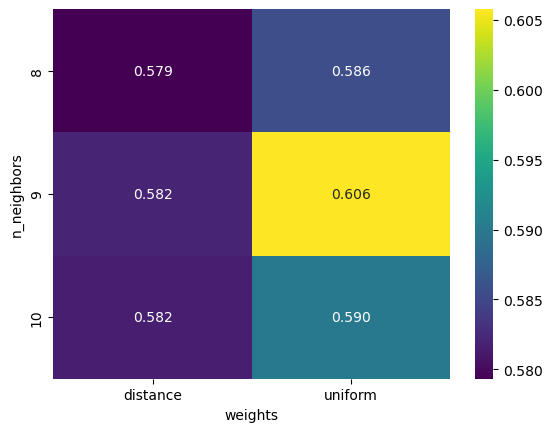

Meilleurs paramètres : {'n_neighbors': 9, 'weights': 'uniform'}
Meilleurs score : 0.6057508436307161


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


predictions_columns = ["Geography_Germany", "Geography_Spain", "Gender_Male", "Tenure", "IsActiveMember", "NumOfProducts", "Age", "Balance"]
X_train = training_df[predictions_columns]
y_train = training_df["Exited"]

# model = DecisionTreeClassifier()
# model = RandomForestClassifier()
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)


# k_scores = {}
# for k in range(1, 10):
#    print(k)
#    model = model = KNeighborsClassifier(n_neighbors=k)
#    cv_scores = cross_val_score(
#       estimator=model,
#       X=X_train,
#       y=y_train,
#       cv=5,
#       scoring="f1"
#    )
#    k_scores[k] = cv_scores.mean()
# plt.scatter(k_scores.keys(), k_scores.values())

param_grid = {
   "n_neighbors": range(8, 11),
   "weights": ['uniform', 'distance'],
   #"metric": ["euclidean"]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="f1")
grid_search.fit(X_train, y_train)
params = grid_search.cv_results_["params"]
scores = grid_search.cv_results_["mean_test_score"]

grid_search_results = pd.DataFrame(params)
grid_search_results["score"] = scores

# grid_search_heatmap = grid_search_results.pivot(index='n_neighbors', columns='weigths', values="score")
grid_search_heatmap = grid_search_results.pivot(index='n_neighbors', columns='weights', values="score")
sns.heatmap(grid_search_heatmap, annot=True, fmt=".3f", cmap="viridis")
plt.show()
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleurs score : {grid_search.best_score_}")

# print(f"Scores de validation croisée: {cv_scores}")
# print(f"Moyenne des scores de validation croisée: {cv_scores.mean()}")

In [443]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

model = KNeighborsClassifier(n_neighbors=9, metric="euclidean")
model.fit(X_train, y_train)

X_test = df_test[predictions_columns]
predictions = model.predict(X_test)
predictions

results = pd.DataFrame({
   "ID": test_set["ID"],
   "Exited": predictions
})

results = results.set_index("ID")

sorted_y = df_test[["ID", "Exited"]].sort_values("ID")
sorted_y

sorted_y_pred = results.sort_values("ID")
sorted_y_pred

accuracy_score(sorted_y["Exited"], sorted_y_pred["Exited"])
precision_score(sorted_y["Exited"], sorted_y_pred["Exited"])
recall_score(sorted_y["Exited"], sorted_y_pred["Exited"])
f1_score(sorted_y["Exited"], sorted_y_pred["Exited"])

0.6039473684210527

# Make Prediction

In [444]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

training_df = df.drop('Exited', axis=1)
training_df = pipeline.fit_transform(training_df)

predictions_columns = ["Geography_Germany", "Geography_Spain", "Gender_Male", "Tenure", "IsActiveMember", "NumOfProducts", "Age", "Balance"]
X = training_df[predictions_columns]
y = df["Exited"]

# model = RandomForestClassifier()
model = KNeighborsClassifier(n_neighbors=9, metric="euclidean")
model.fit(X, y)

df_test = pd.read_csv('data/test_data.csv')
df_test = pipeline.transform(df_test)
df_test

X_test = df_test[predictions_columns]
predictions = model.predict(X_test)
predictions

results = pd.DataFrame({
   "ID": df_test["ID"],
   "Exited": predictions
})
results = results.set_index("ID")
results
results.to_csv("submission.csv")